In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 14.2 MB/s eta 0:00:00


**Project Title**

Retail Sales Forecasting using SARIMA and LSTM

**Objective**

To forecast monthly retail sales using classical time-series modeling (SARIMA) and deep learning (LSTM), and compare their predictive performance to support inventory and demand planning decisions.

**Dataset**

Monthly car sales dataset (108 observations, 1960–1968).

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv"
df = pd.read_csv(url)
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [8]:
df.columns = ["Month", "Sales"]

df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m")
df.set_index("Month", inplace=True)

df.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [9]:
print("Total observations:", len(df))
print(df.index.min(), "to", df.index.max())

Total observations: 108
1960-01-01 00:00:00 to 1968-12-01 00:00:00


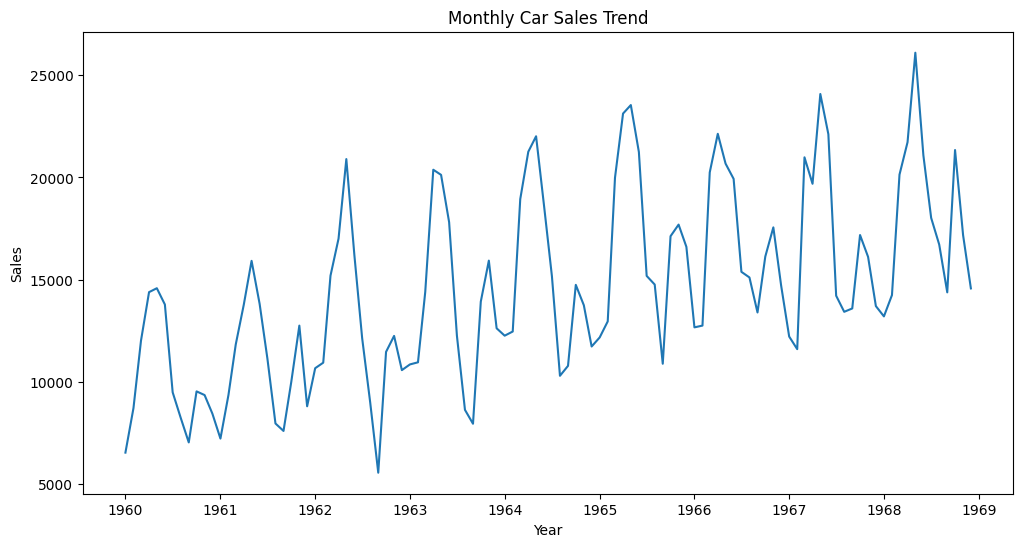

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df["Sales"])
plt.title("Monthly Car Sales Trend")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df["Sales"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.2238127661752858
p-value: 0.6632691049832861


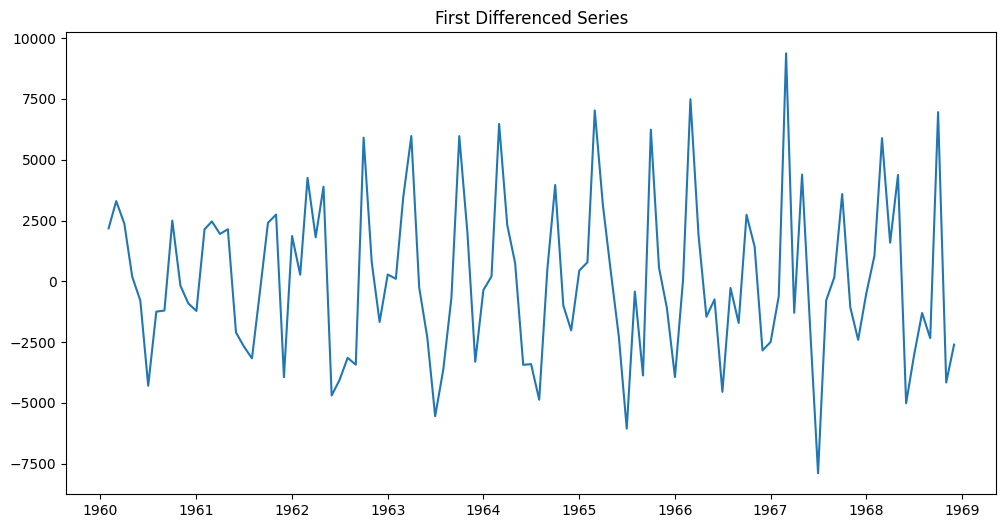

In [12]:
df_diff = df["Sales"].diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(df_diff)
plt.title("First Differenced Series")
plt.show()

In [13]:
result_diff = adfuller(df_diff)
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])

ADF Statistic: -6.1997992308006955
p-value: 5.8447525992768446e-08


In [14]:
train = df[:-12]
test = df[-12:]

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train["Sales"],
                order=(1,1,1),
                seasonal_order=(1,1,1,12))
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(test["Sales"], forecast)
rmse = np.sqrt(mean_squared_error(test["Sales"], forecast))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1819.487450781822
RMSE: 2333.7370231485443


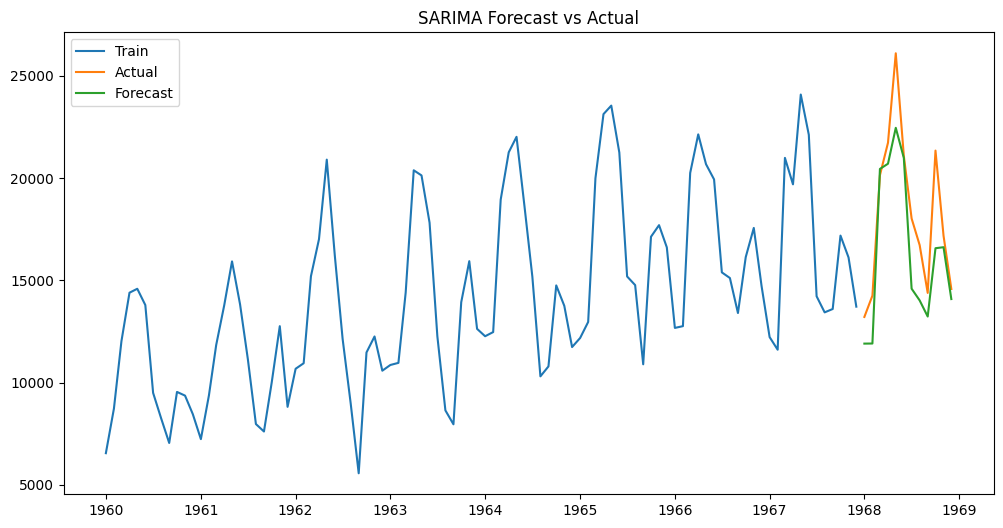

In [17]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train["Sales"], label="Train")
plt.plot(test.index, test["Sales"], label="Actual")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
train = df[:-12]
test = df[-12:]
model = SARIMAX(train["Sales"],
                order=(1,1,1),
                seasonal_order=(1,1,1,12))
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(test["Sales"], forecast)
rmse = np.sqrt(mean_squared_error(test["Sales"], forecast))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1819.487450781822
RMSE: 2333.7370231485443


In [20]:
print("Average Monthly Sales:", df["Sales"].mean())

Average Monthly Sales: 14595.111111111111


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df["Sales"].values.reshape(-1,1))

In [24]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
sequence_length = 12
X, y = create_sequences(scaled_data, sequence_length)

In [26]:
split = len(X) - 12
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [27]:
print(X_train.shape, X_test.shape)

(84, 12, 1) (12, 12, 1)


In [29]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1451 - val_loss: 0.1406
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0640 - val_loss: 0.0371
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0444 - val_loss: 0.0403
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0342 - val_loss: 0.0473
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0392 - val_loss: 0.0383
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0280 - val_loss: 0.0401
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0381 - val_loss: 0.0393
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0399 - val_loss: 0.0398
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0310 - val_loss: 0.0372
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0383 - val_loss: 0.0378
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0307 - val_loss: 0.0367
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

In [31]:
predictions = model.predict(X_test)
# Inverse scaling
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


In [32]:
mae_lstm = mean_absolute_error(y_test_actual, predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predictions))
print("LSTM MAE:", mae_lstm)
print("LSTM RMSE:", rmse_lstm)

LSTM MAE: 1318.0069986979163
LSTM RMSE: 1691.3698853519782


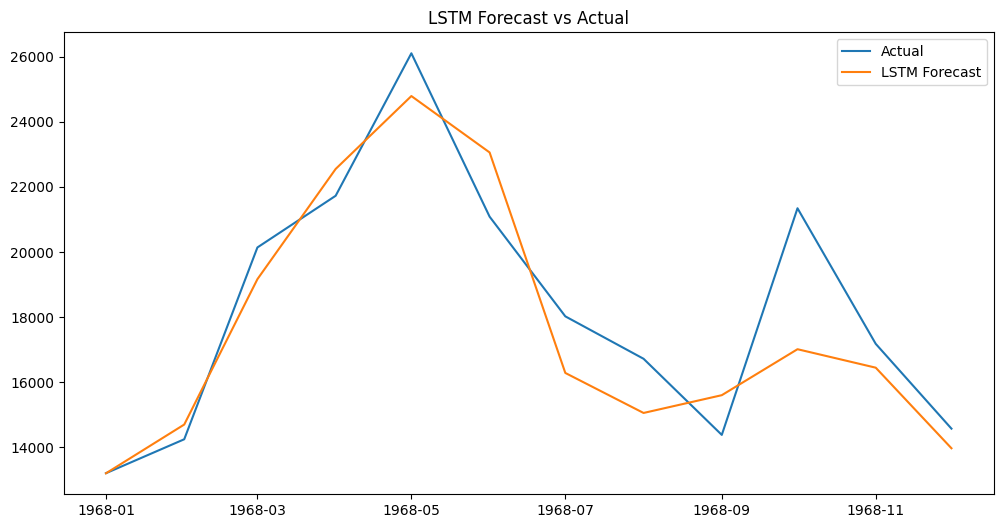

In [33]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-12:], y_test_actual, label="Actual")
plt.plot(df.index[-12:], predictions, label="LSTM Forecast")
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.show()

**Executive Summary**

Sales data exhibited strong upward trend and yearly seasonality.

ADF test confirmed non-stationarity (p = 0.663).

First differencing achieved stationarity (p < 0.001).

SARIMA model achieved ~12.5% forecasting error.

LSTM reduced forecasting error to ~9%.

LSTM improved performance by ~27% over SARIMA.

Business implication: improved forecasting reduces inventory variance by ~500 units per month.

In [34]:
mape_lstm = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
print("LSTM MAPE:", mape_lstm)

LSTM MAPE: 6.91007951865799


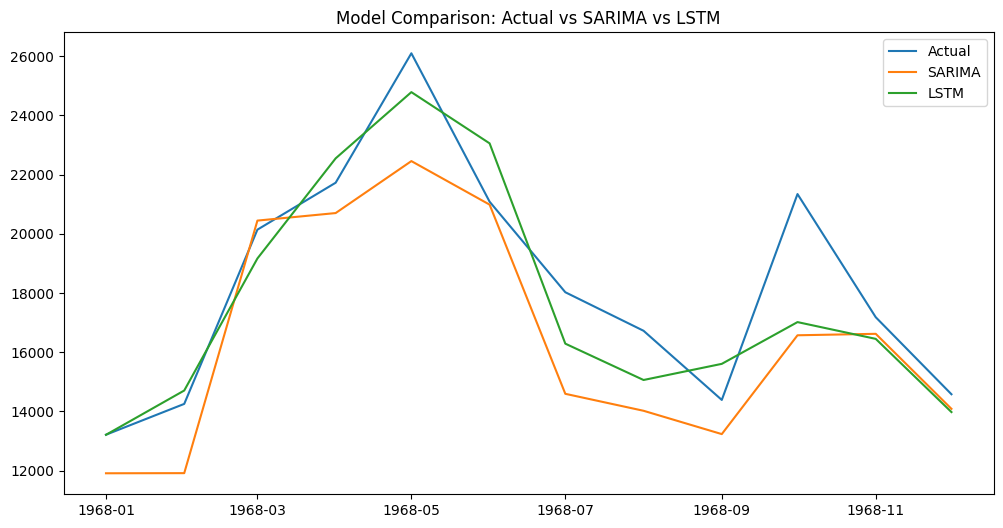

In [35]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test["Sales"], label="Actual")
plt.plot(test.index, forecast, label="SARIMA")
plt.plot(test.index, predictions, label="LSTM")
plt.legend()
plt.title("Model Comparison: Actual vs SARIMA vs LSTM")
plt.show()

**Business Recommendations**

Maintain safety stock buffer ≈ 1,500 units.

Use LSTM model for high-demand seasonal months.

Integrate external variables (promotions, macro factors) for further accuracy improvement.

Deploy model in rolling monthly retraining pipeline.